# Using a pretrained CNN

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task.

There are two ways to use a pretrained network: _feature extraction_ and _fine-tuning_.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, trained from scratch.

Even if it's not the state-of-the-art, and is also quite cumbersome, `VGG16` is a good example because it has a structure similar to the CNN built in the previous exercises.

In [3]:
from tensorflow.keras.applications import VGG16

#### Define convolutional base

In [4]:
conv_base = VGG16(
    weights='imagenet',        # checkpoints from when to initialize the model
    include_top=False,         # when True, includes the fully connected classifier network
    input_shape=(150, 150, 3)  # shape of the image tensors to feed the network with
)
conv_base.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

At this point there are **two alternatives** to perform feature extraction:
- Running the convolutional base of the network over the dataset, record the outputs in a Numpy array on disk and then use it to feed a densely connected classifier. Cheap, but impossible to use _data augmentation_
- Extending the model by adding `Dense` layers on top and run the whole network end to end on the inpit data. Data augmentation is possible, but the solution is far more expensive than the previous one

### Fast feature extraction _without_ data augmentation

In [5]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
TRAIN_DIR = "./datasets/cats_and_dogs_small/train"
VALIDATION_DIR = "./datasets/cats_and_dogs_small/validation"
TEST_DIR = "./datasets/cats_and_dogs_small/test"

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

#### Extract features from convolution base

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # shape of the output of the last layer of the conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
        # Since generators yield data indefinitely in a loop, we must `break` after every image has been seen once.
            break
    return features, labels
    
train_features, train_labels = extract_features(TRAIN_DIR, 2000)
validation_features, validation_labels = extract_features(VALIDATION_DIR, 1000)
test_features, test_labels = extract_features(TEST_DIR, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


At this point we need to flatten the feature array in order to feed the classifier, exactly as a `Flatted` layer would do. Currently, the features have shape (`samples, 4, 4, 512`), so new array will have a shape equal to (`samples, (4 * 4 * 512)`).

In [11]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

#### Define and train the densely connected classifier

The training should be very fast, since we have to do with a small network.

In [12]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy']
)

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 656us/sample - loss: 0.6067 - accuracy: 0.6615 - val_loss: 0.4451 - val_accuracy: 0.8250
Epoch 2/30
2000/2000 [==============================] - 1s 471us/sample - loss: 0.4309 - accuracy: 0.7965 - val_loss: 0.3564 - val_accuracy: 0.8670
Epoch 3/30
2000/2000 [==============================] - 1s 475us/sample - loss: 0.3643 - accuracy: 0.8460 - val_loss: 0.3227 - val_accuracy: 0.8690
Epoch 4/30
2000/2000 [==============================] - 1s 488us/sample - loss: 0.3081 - accuracy: 0.8730 - val_loss: 0.2936 - val_accuracy: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 498us/sample - loss: 0.2901 - accuracy: 0.8835 - val_loss: 0.2827 - val_accuracy: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 477us/sample - loss: 0.2674 - accuracy: 0.8920 - val_loss: 0.3033 - val_accuracy: 0.8580
Epoch 7/30
2000/2000 [==============================] - 1s 506us

#### Plot loss and accuracy

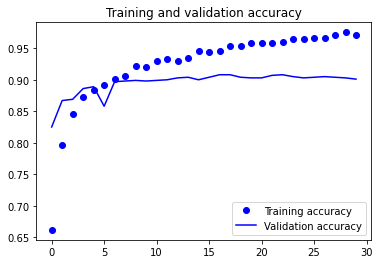

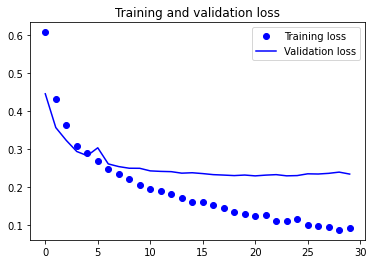

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We obtain a good 90% validation accuracy, which outperforms the CNN from scratch we built in the previous notebook. On the other hand, due to the impossibility to add data augmentation we start also to overfit quite early, despite of using `Dropout` with a fairly large rate.

### Feature extraction _with_ data augmentation

This technique allows data augmentation during training, but is also expensive. Absolutely not recommended without at least one GPU, since we'll have to do with more than 16 millions parameters.

#### Add a densely connected classifier on top of the convolutional base

By _freezing_ the `conv_base` we will reduce the amount of weights that will be trained: only those who belong the classifier on top.

In [74]:
conv_base = VGG16(
    weights='imagenet',        # checkpoints from when to initialize the model
    include_top=False,         # when True, includes the fully connected classifier network
    input_shape=(150, 150, 3)  # shape of the image tensors to feed the network with
)

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


#### Setup generators with data augmentation

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Do not apply data augmentation on validation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Compile and train the model

In [76]:
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 187s 2s/step - loss: 0.6156 - accuracy: 0.6785 - val_loss: 0.4712 - val_accuracy: 0.8140
Epoch 2/30
100/100 [==============================] - 191s 2s/step - loss: 0.4978 - accuracy: 0.7765 - val_loss: 0.3822 - val_accuracy: 0.8530
Epoch 3/30
100/100 [==============================] - 191s 2s/step - loss: 0.4560 - accuracy: 0.7955 - val_loss: 0.3407 - val_accuracy: 0.8650
Epoch 4/30
100/100 [==============================] - 192s 2s/step - loss: 0.4126 - accuracy: 0.8200 - val_loss: 0.3232 - val_accuracy: 0.8790
Epoch 5/30
100/100 [==============================] - 192s 2s/step - loss: 0.3893 - accuracy: 0.8255 - val_loss: 0.2985 - val_accuracy: 0.8780
Epoch 6/30
100/100 [==============================] - 193s 2s/step - loss: 0.3792 - accuracy: 0.8330 - val_loss: 0.2906 - val_accuracy: 0.8870
Epoch 7/30
100/100 [=============================

In [77]:
model.save('./models/cats_and_dogs_small_3.h5')

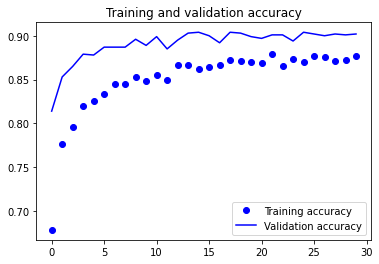

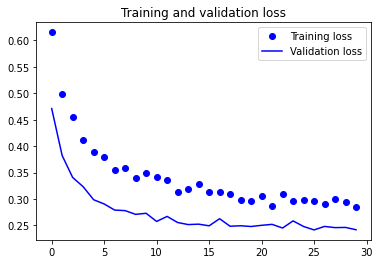

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We obtain again a good 90% validation accuracy, which outperforms the CNN from scratch. Please note also how, thanks to data augmentation, the model does not overfit the same way it does in the previous example.

### Fine tuning
Fine tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the new added part of the model (the densely connected classifier in our case) and these top layers.

The steps for fine-tuning a network are as follow:

- Add your custom network on top of an already trained base network.
- Freeze the base network.
- Train the part you added.
- Unfreeze some layers in the base network.
- Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, and then freeze individual layers inside of it.

#### Unfreeze selected layers

In [79]:
# Unfreeze the last 3 layers
conv_base.trainable = True 
set_trainable = False

for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

        
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### Compile and fine-tune the network

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

In [80]:
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 220s 2s/step - loss: 0.2879 - accuracy: 0.8805 - val_loss: 0.2179 - val_accuracy: 0.9070
Epoch 2/100
100/100 [==============================] - 219s 2s/step - loss: 0.2638 - accuracy: 0.8885 - val_loss: 0.2115 - val_accuracy: 0.9180
Epoch 3/100
100/100 [==============================] - 219s 2s/step - loss: 0.2624 - accuracy: 0.8925 - val_loss: 0.1986 - val_accuracy: 0.9250
Epoch 4/100
100/100 [==============================] - 218s 2s/step - loss: 0.2249 - accuracy: 0.9005 - val_loss: 0.2031 - val_accuracy: 0.9260
Epoch 5/100
100/100 [==============================] - 218s 2s/step - loss: 0.2105 - accuracy: 0.9080 - val_loss: 0.1926 - val_accuracy: 0.9270
Epoch 6/100
100/100 [==============================] - 219s 2s/step - loss: 0.1959 - accuracy: 0.9210 - val_loss: 0.1946 - val_accuracy: 0.9270
Epoch 7/100
100/100 [======================

100/100 [==============================] - 219s 2s/step - loss: 0.0344 - accuracy: 0.9880 - val_loss: 0.2150 - val_accuracy: 0.9460
Epoch 57/100
100/100 [==============================] - 219s 2s/step - loss: 0.0370 - accuracy: 0.9875 - val_loss: 0.2135 - val_accuracy: 0.9470
Epoch 58/100
100/100 [==============================] - 219s 2s/step - loss: 0.0323 - accuracy: 0.9885 - val_loss: 0.2142 - val_accuracy: 0.9420
Epoch 59/100
100/100 [==============================] - 220s 2s/step - loss: 0.0346 - accuracy: 0.9875 - val_loss: 0.2042 - val_accuracy: 0.9440
Epoch 60/100
100/100 [==============================] - 220s 2s/step - loss: 0.0315 - accuracy: 0.9870 - val_loss: 0.2109 - val_accuracy: 0.9430
Epoch 61/100
100/100 [==============================] - 219s 2s/step - loss: 0.0325 - accuracy: 0.9910 - val_loss: 0.2080 - val_accuracy: 0.9430
Epoch 62/100
100/100 [==============================] - 220s 2s/step - loss: 0.0414 - accuracy: 0.9850 - val_loss: 0.2402 - val_accuracy: 0.938

In [81]:
model.save('models/cats_and_dogs_small_4.h5')

#### Plot metrics

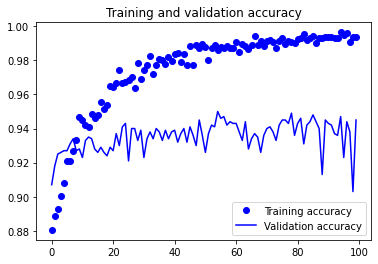

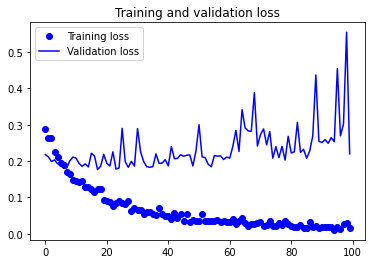

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

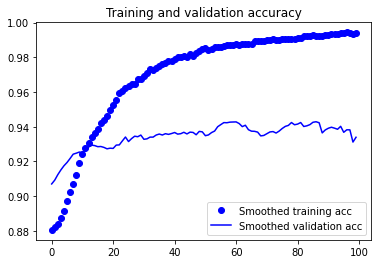

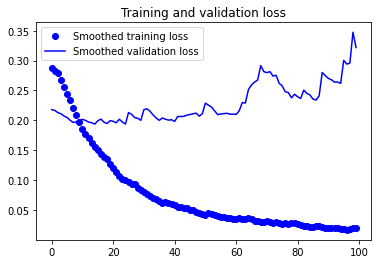

In [86]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look much cleaner and more stable. We are seeing a nice 4% absolute improvement.

Note that **the loss curve does not show any real improvement** (in fact, it is deteriorating). How could accuracy improve if the loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability prediced by the model. The model may still be improving even if this isn't reflected in the average loss.

#### Evaluate the model on test data

In [87]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print('test accuracy:', test_accuracy)

Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
50/50 [==============================] - 59s 1s/step - loss: 0.3198 - accuracy: 0.9430
test accuracy: 0.943
